In [0]:
#           _____                _____                    _____                    _____                    _____                    _____          
#         /\    \              /\    \                  /\    \                  /\    \                  /\    \                  /\    \         
#        /::\    \            /::\    \                /::\    \                /::\    \                /::\    \                /::\    \        
#       /::::\    \           \:::\    \              /::::\    \              /::::\    \              /::::\    \               \:::\    \       
#      /::::::\    \           \:::\    \            /::::::\    \            /::::::\    \            /::::::\    \               \:::\    \      
#     /:::/\:::\    \           \:::\    \          /:::/\:::\    \          /:::/\:::\    \          /:::/\:::\    \               \:::\    \     
#    /:::/__\:::\    \           \:::\    \        /:::/__\:::\    \        /:::/__\:::\    \        /:::/__\:::\    \               \:::\    \    
#    \:::\   \:::\    \          /::::\    \      /::::\   \:::\    \      /::::\   \:::\    \      /::::\   \:::\    \              /::::\    \   
#  ___\:::\   \:::\    \        /::::::\    \    /::::::\   \:::\    \    /::::::\   \:::\    \    /::::::\   \:::\    \    ____    /::::::\    \  
# /\   \:::\   \:::\    \      /:::/\:::\    \  /:::/\:::\   \:::\    \  /:::/\:::\   \:::\____\  /:::/\:::\   \:::\    \  /\   \  /:::/\:::\    \ 
#/::\   \:::\   \:::\____\    /:::/  \:::\____\/:::/  \:::\   \:::\____\/:::/  \:::\   \:::|    |/:::/  \:::\   \:::\____\/::\   \/:::/  \:::\____\
#\:::\   \:::\   \::/    /   /:::/    \::/    /\::/    \:::\  /:::/    /\::/   |::::\  /:::|____|\::/    \:::\  /:::/    /\:::\  /:::/    \::/    /
# \:::\   \:::\   \/____/   /:::/    / \/____/  \/____/ \:::\/:::/    /  \/____|:::::\/:::/    /  \/____/ \:::\/:::/    /  \:::\/:::/    / \/____/ 
#  \:::\   \:::\    \      /:::/    /                    \::::::/    /         |:::::::::/    /            \::::::/    /    \::::::/    /          
#   \:::\   \:::\____\    /:::/    /                      \::::/    /          |::|\::::/    /              \::::/    /      \::::/____/           
#    \:::\  /:::/    /    \::/    /                       /:::/    /           |::| \::/____/               /:::/    /        \:::\    \           
#     \:::\/:::/    /      \/____/                       /:::/    /            |::|  ~|                    /:::/    /          \:::\    \          
#      \::::::/    /                                    /:::/    /             |::|   |                   /:::/    /            \:::\    \         
#       \::::/    /                                    /:::/    /              \::|   |                  /:::/    /              \:::\____\        
#        \::/    /                                     \::/    /                \:|   |                  \::/    /                \::/    /        
#         \/____/                                       \/____/                  \|___|                   \/____/                  \/____/         

In [0]:
!pip install gym box2d-py pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import glob
import io
import base64
import numpy as np
import gym as gym
from gym.wrappers import Monitor
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython.display import HTML
from IPython import display as ipythondisplay
import random
import copy
import tensorflow.contrib.eager as tfe
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)
tf.enable_eager_execution()

%matplotlib inline

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env


# DQN
The parameterized Q update formula is:
## $ Q(S_{t}, A_{t}, \theta) \leftarrow R_{t+1} + \gamma \ \underset{a}{\operatorname{max}} Q(S_{t+1}, a, \theta_{target}) $
where   
$ Q(S_{t}, A_{t}, \theta) $ is the Q network  
$  Q(S_{t+1}, a, \theta_{target}) $ is the target Q network (a copy of Q network that is updated to be Q at regular intervals)

#    
#   
So what we're saying is Q is what we believe Q is at, while we use Q target to calculate the Q value of the next state.  
The error then is the difference between the left and right side of the formula.
## $ L(\theta) = Q(S_{t}, A_{t}, \theta) - y $  
where $ y = [R_{t+1} + \gamma \ \underset{a}{\operatorname{max}} Q(S_{t+1}, a, \theta_{target})] $




In [4]:
"""
As an Illustration, let's assume our Q values, Qt (for Q Target), reward and gamma are as below:
you can see how DQN is slightly different from Double DQN
"""

# Q Neural Net output for actions [left, right], 
# i.e. Q(s) which returns all possible action values 
# so Q(s, 1) = 4 and Q(s, 0) = 2
Q = [2, 4]   
Qt = [5, 3]  # Target Q Neural Net output for actions [left, right], i.e. Q(s) which returns all possible action values 
R = 1
gamma = 1

# For DQN
y = R + gamma * np.max(Qt)  # where np.max(Qt) gives 5, so 1 + 5 = 6
print(y)

6


In [0]:
#  _____            _     
# |_   _|___   ___ | |___ 
#   | | / _ \ / _ \| / __|
#   | || (_) | (_) | \__ \
#   |_| \___/ \___/|_|___/
#                         
# Just run it. Epsilon is the same as before

class Epsilon(object):
    def __init__(self, start=1.0, end=0.01, update_decrement=0.01):
        self._start = start
        self._end = end
        self._update_decrement = update_decrement
        self._value = self._start
        self.isTraining = True
    
    def decrement(self, count=1):
        self._value = max(self._end, self._value - self._update_decrement*count)
        return self
        
    def value(self):
        if not self.isTraining:
            return 0.0
        else:
            return self._value


          
class RewardHistory(list):
  def plot(self):
    R = np.array(self)
    mu = np.mean(R, axis=0)
    std = np.std(R, axis=0)
    f, axarr = plt.subplots(1, 2)
    f.set_figheight(5)
    f.set_figwidth(20)
    f.subplots_adjust(hspace=0.2)
    axarr[0].plot(mu)
    axarr[0].set_title('Mean reward')
    axarr[0].set_xlabel("Episodes")
    axarr[0].set_ylabel("Reward")
    axarr[1].set_title('Std')
    axarr[1].set_xlabel("Episodes")
    axarr[1].set_ylabel("std")
    axarr[1].plot(std)
    plt.show()



In [0]:
#  ____             _               __  __                                 
# |  _ \  ___ _ __ | | __ _ _   _  |  \/  | ___ _ __ ___   ___  _ __ _   _ 
# | |_) |/ _ \ '_ \| |/ _` | | | | | |\/| |/ _ \ '_ ` _ \ / _ \| '__| | | |
# |  _ <|  __/ |_) | | (_| | |_| | | |  | |  __/ | | | | | (_) | |  | |_| |
# |_| \_\\___| .__/|_|\__,_|\__, | |_|  |_|\___|_| |_| |_|\___/|_|   \__, |
#            |_|            |___/                                    |___/ 
# Just run it


from collections import namedtuple
import random
import numpy as np


Transition = namedtuple("Transition", ["s", "a", "s_1", "r", "done"])


class ReplayMemory(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.position = 0

  def push(self, item):
    """Saves a transition."""
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = item
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    out = random.sample(self.memory, batch_size)
    batched = Transition(*zip(*out))
    s = np.array(list(batched.s))
    # a = np.array(list(batched.a))
    a = np.expand_dims(np.array(list(batched.a)), axis=1)
    s_1 = np.array(list(batched.s_1))
    r = np.expand_dims(np.array(list(batched.r)), axis=1)
    done = np.expand_dims(np.array(list(batched.done)), axis=1)
    return [s, a, s_1, r, done]

  def __len__(self):
    return len(self.memory)

  def __str__(self):
    result = []
    for i in range(self.__len__()):
      result.append(self.memory[i].__str__() + " \n")
    return "".join(result)

In [7]:
"""
Play around with the replay memory to understand how it works. 
Replay memory is one of the key elements to the DQN, where we collect large 
samples of transitions (state, action, state_t+1, reward, done)
from many roll outs (episodes)
Then we sample batches from this memory to use as data to train our Q network.
"""

# Learn how memory works
memory = ReplayMemory(capacity=5) # Create a replay memory with total capacity of 5
for i in range(11):
  # generate some data and add to memory, 
  # we use the namedtuple Transition (defined above) to group our transition variables
  # Transitions are created with:
  # Transition(state, action, state_t+1, reward, done)
  t = Transition([0, 1, 2, i], [0, 1], [4, 5, 6, i*2], i, i%2==0) 
  memory.push(t)  # add to memory

print(memory)  # notice the first 6 transitions don't exist because our memory is only of size 5


s, a, s1, r, done = memory.sample(2) # randomly sample 2 transitions from our total memory of 5
print("State:\n", s)
print("Action:\n", a)
print("State t+1:\n", s1)
print("Reward:\n", r)
print("Done:\n", done)

Transition(s=[0, 1, 2, 10], a=[0, 1], s_1=[4, 5, 6, 20], r=10, done=True) 
Transition(s=[0, 1, 2, 6], a=[0, 1], s_1=[4, 5, 6, 12], r=6, done=True) 
Transition(s=[0, 1, 2, 7], a=[0, 1], s_1=[4, 5, 6, 14], r=7, done=False) 
Transition(s=[0, 1, 2, 8], a=[0, 1], s_1=[4, 5, 6, 16], r=8, done=True) 
Transition(s=[0, 1, 2, 9], a=[0, 1], s_1=[4, 5, 6, 18], r=9, done=False) 

State:
 [[0 1 2 7]
 [0 1 2 8]]
Action:
 [[[0 1]]

 [[0 1]]]
State t+1:
 [[ 4  5  6 14]
 [ 4  5  6 16]]
Reward:
 [[7]
 [8]]
Done:
 [[False]
 [ True]]


In [8]:
"""
Define a Linear Q network model using Tensorflow Eager. 
TF Eager is similar to Pytorch and a lot easier to debug compared to graph mode. 

If you want to use this please get familiar with how it works, if this cell doesn't
make sense to you after playing around then do the TF Eager tutorial. 
https://www.tensorflow.org/tutorials/eager/eager_basics
https://www.tensorflow.org/guide/eager


What's happening in this cell is an illustration of:
- defining a model, think Q
- creating a copy of it, think Q_target
- run some input to it, think states
- train it 50 times with a batch of action and target value, with the idea that 
  given the state input of [1, 1, 1, 1] the best action is 1 with a Q value of 5.
  given the state input of [-1, -1, -1, -1] the best action is 0 with a Q value of 10.

- notice that Q network has moved, but Q_target hasn't
- copy Q weights to Q_target and validate that the results match Q

"""

#   ___       _   _      _                      _    
#  / _ \     | \ | | ___| |___      _____  _ __| | __
# | | | |    |  \| |/ _ \ __\ \ /\ / / _ \| '__| |/ /
# | |_| |    | |\  |  __/ |_ \ V  V / (_) | |  |   < 
#  \__\_\    |_| \_|\___|\__| \_/\_/ \___/|_|  |_|\_\
#                                                    

class LinearModel(tf.keras.Model):
    def __init__(self, nb_actions=2):
        super().__init__(self)
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.dense2 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense22 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(units=nb_actions)

    def call(self, input):
        result = self.dense1(input)
#         result = self.dense2(result)
#         result = self.dense22(result)
        result = self.dense3(result)
        return result
    
nb_actions = 2

"""
Tests
"""
# Define 2 models
model = LinearModel(nb_actions=nb_actions)
model2 = LinearModel(nb_actions=nb_actions)

# create some arbitrary input or state
state = tf.constant([
    [1, 1, 1, 1],
    [-1, -1, -1, -1],
    [1, 1, 1, 1]
], dtype=tf.float32)
print("Input state:", state)

# initialize both models, with TF eager model weights are not initialized until it's been called at least once
model(state)
model2(state)

# copy weights across
model2.set_weights(model.get_weights())

print("\nTesting result for model1:", model(state))
print("\nTesting result for model2:", model2(state))

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

# # keep results for plotting
print("\nTraining model 1 for 50 epochs")
num_epochs = 50
for epoch in range(num_epochs):
    inputs = state
    targets = tfe.Variable([[5], [10], [5]], dtype="float32")
    actions = tf.one_hot([1, 0, 1], depth=2, dtype="float32") # one_hot_labeled actions

#     # Optimize the model using TF Eager
    with tfe.GradientTape() as tape:
        q = model(inputs)   # run the model with the inputs (states)
        # y_hat = q*one_hot_actions because we're only training the Q value where we took the action
        #         i.e. Q() outputs 2 actions, but we only back prop from the action value 
        #         matching the action we took, hope this makes sense
        y_hat = tf.reduce_sum(q * actions, keep_dims=True, reduction_indices=1)  # 
        loss = (y_hat - targets) ** 2
        loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())
  
        
print("\nmodel 1 after training", model(state))
print("\nmodel 2 stays the same", model2(state))
model2.set_weights(model.get_weights())
print("\nmodel 2 changes after loading weights", model2(state))


Input state: tf.Tensor(
[[ 1.  1.  1.  1.]
 [-1. -1. -1. -1.]
 [ 1.  1.  1.  1.]], shape=(3, 4), dtype=float32)

Testing result for model1: tf.Tensor(
[[ 0.66953355  0.6367032 ]
 [-0.66953355 -0.6367032 ]
 [ 0.66953355  0.6367032 ]], shape=(3, 2), dtype=float32)

Testing result for model2: tf.Tensor(
[[ 0.66953355  0.6367032 ]
 [-0.66953355 -0.6367032 ]
 [ 0.66953355  0.6367032 ]], shape=(3, 2), dtype=float32)

Training model 1 for 50 epochs

model 1 after training tf.Tensor(
[[-7.943417   4.9476385]
 [10.5311985 -2.984845 ]
 [-7.943417   4.9476385]], shape=(3, 2), dtype=float32)

model 2 stays the same tf.Tensor(
[[ 0.66953355  0.6367032 ]
 [-0.66953355 -0.6367032 ]
 [ 0.66953355  0.6367032 ]], shape=(3, 2), dtype=float32)

model 2 changes after loading weights tf.Tensor(
[[-7.943417   4.9476385]
 [10.5311985 -2.984845 ]
 [-7.943417   4.9476385]], shape=(3, 2), dtype=float32)


# Exercise, build a DQN for the Cartpole env

### Step 1: Store transitions into memory in the train() method

### Step 2: Modify get_action() to act based on output of Q network when acting greedily, currently it's all random

### Step 3: Write the Q training logic in the train_q() method

### Step 4: Play around with the various params to understand it's impact on the performance of the solution
- epsilon
- gamma
- optimizer learning rate
- train_q_per_step -  how often we train the Q network
- train_q_batch_size -  batch size we use to train Q
- steps_before_training -  how many steps we take before we start training the Q network
- target_q_update_frequency - how many steps we take before we update Q network
- ReplayMemory capacity



Total Steps: 15481
Total Steps: 19434


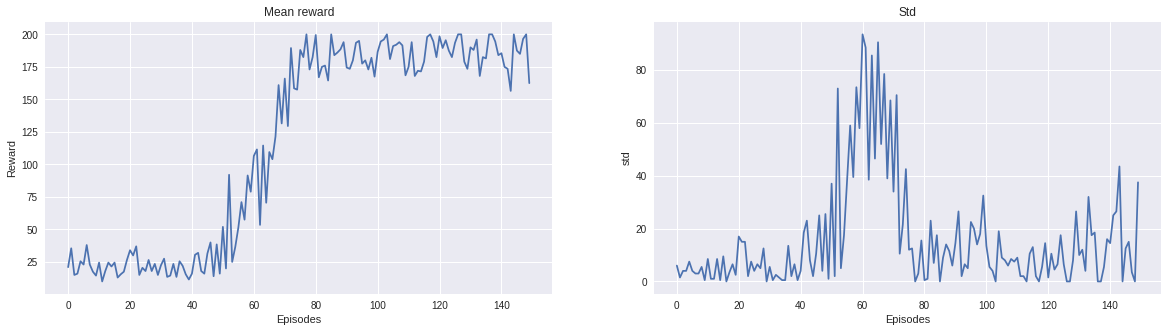

In [11]:
class DQNLinearLearner(object):
    def __init__(self, env=None, double_Q=False):
        self.env = env
        self.epsilon = Epsilon(start=1.0, end=0.01, update_decrement=0.015)
        self.gamma = 0.99
        self.train_q_per_step = 4  # train q every 4 steps
        self.train_q_batch_size = 256  # q training batch size
        self.steps_before_training = 500  # run 500 steps before starting training
        self.target_q_update_frequency = 100  # how often to copy weights from Q to Qt
        
        self.memory = ReplayMemory(capacity=10000)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-6)
        self.Q = LinearModel(env.action_space.n)   # define Q network
        self.Qt = LinearModel(env.action_space.n)  # define Qt target network
        self.Qt.set_weights(self.Q.get_weights())

        self.reset()
        self.episode_rewards = []
        self.epsilon_log = []
        

    def get_action(self, s):
        if np.random.rand() > self.epsilon.value():
            #          
            #  _____            _       
            # |_   _|___     __| | ___  
            #   | | / _ \   / _` |/ _ \ 
            #   | || (_) | | (_| | (_) |
            #   |_| \___/   \__,_|\___/ 
            #                           
            # - convert state to tensor to input into the Q NN
            # - get Q NN to calculate all the action values for this state, Q(s, A)
            # - select the greedy action from the NN outputs
            #action = self.env.action_space.sample()
            s = self.state_to_tensor(s)
            actions = self.Q(s).numpy()
            action = np.argmax(actions)
        else:
            action = self.env.action_space.sample()
        return action

    def state_to_tensor(self, s):
        x = tf.constant(s, dtype="float32")
        x = tf.expand_dims(x, axis=0)
        return x
    
    def reset(self):
        self.s = self.env.reset()
    
    def train(self, nb_episodes=1):
        self.epsilon.isTraining = True
        step = 0
        
        for episode in range(nb_episodes):
            self.reset()
            episode_reward = 0
            
            while True:
                action = self.get_action(self.s)
                s_1, r, done, _ = self.env.step(action)
                
                memory_done = done
#                 if done and episode_reward >= 199:
#                   memory_done = False
                #          
                #  _____            _       
                # |_   _|___     __| | ___  
                #   | | / _ \   / _` |/ _ \ 
                #   | || (_) | | (_| | (_) |
                #   |_| \___/   \__,_|\___/ 
                #  - store transition into memory                         
                transition = Transition(self.s, action, s_1, r, memory_done)
                self.memory.push(transition)
                
                episode_reward += r
                step += 1
                self.s = s_1
                
                if done:
                    break;
                
                if step % self.train_q_per_step == 0 and step > self.steps_before_training:
                    self.train_q()
                    
                if step % self.target_q_update_frequency == 0 and step > self.steps_before_training:
                    self.update_target_q()

            if step > self.steps_before_training:
                self.epsilon.decrement() # decrement epsilon per episode
            self.episode_rewards.append(episode_reward)
            self.epsilon_log.append(self.epsilon.value())
        print("Total Steps:", step)
    
    def train_q(self):
        if self.train_q_batch_size >= len(self.memory):
            return
        
        s, a, s_1, r, done = self.memory.sample(self.train_q_batch_size)
        s = tf.constant(s, dtype=tf.float32)
        a = tf.squeeze(tf.constant(a, dtype=tf.int32))
        a_one_hot = tf.one_hot(tf.squeeze(a), depth=self.env.action_space.n, dtype=tf.float32)
        s_1 = tf.constant(s_1, dtype=tf.float32)
        r = tf.constant(r, dtype=tf.float32)
        done = tf.constant(1-done, dtype=tf.float32)
        
        #          
        #  _____            _       
        # |_   _|___     __| | ___  
        #   | | / _ \   / _` |/ _ \ 
        #   | || (_) | | (_| | (_) |
        #   |_| \___/   \__,_|\___/ 
        #                           
        #
        
        # Calculate q values using Qt (Q target network)  -> Qt
        Qt = self.Qt(s_1)
        # Calculate the targets using the bellman equation: targets = r + done * gamma * Max_of_Qt    # why is done part of this equation?
        targets = r + done * self.gamma * tf.reduce_max(Qt, axis=1, keep_dims=True)
        
        # Start tracking gradients
        with tfe.GradientTape() as tape:
            # run the model with the inputs (states)
            q = self.Q(s)
            # y_hat = q*one_hot_actions
            y_hat = tf.reduce_sum(q * a_one_hot, keep_dims=True, reduction_indices=1)
            # define your loss function between y_hat and targets
            loss = (y_hat - targets) ** 2
            loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, self.Q.variables)
        optimizer.apply_gradients(zip(grads, self.Q.variables),
                                  global_step=tf.train.get_or_create_global_step())

    def update_target_q(self):
        self.Qt.set_weights(self.Q.get_weights())
        
    def run(self, env):
        self.env = env
        self.reset()
        self.epsilon.isTraining = False
        episode_reward = 0
        while True:
            self.env.render()
            action = self.get_action(self.s)
            s_1, r, done, _ = self.env.step(action)
            episode_reward += r
            self.s = s_1

            if done:
                break;
        
        self.env.close()
        print("Total Reward: ", episode_reward)
        
        
"""
RewardHistory is a class that takes collections of values and plots the mean and std
so we can run the training algorithm x times to see an average performance 
rather than 1 at a time

To run 5 times just change range(1) to range(5)
"""
reward_history = RewardHistory()
for i in range(2):
    env = gym.make("CartPole-v0")
    learner = DQNLinearLearner(env)
    learner.train(150)
    reward_history.append(learner.episode_rewards)

reward_history.plot()

In [22]:
env = wrap_env(gym.make("CartPole-v0"))
for i in range(1):
    learner.run(env)
    show_video()

Total Reward:  200.0


# Lunar lander

https://github.com/openai/gym/wiki/Leaderboard#lunarlander-v2

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.
LunarLander-v2 defines "solving" as getting average reward of 200 over 100 consecutive trials.=


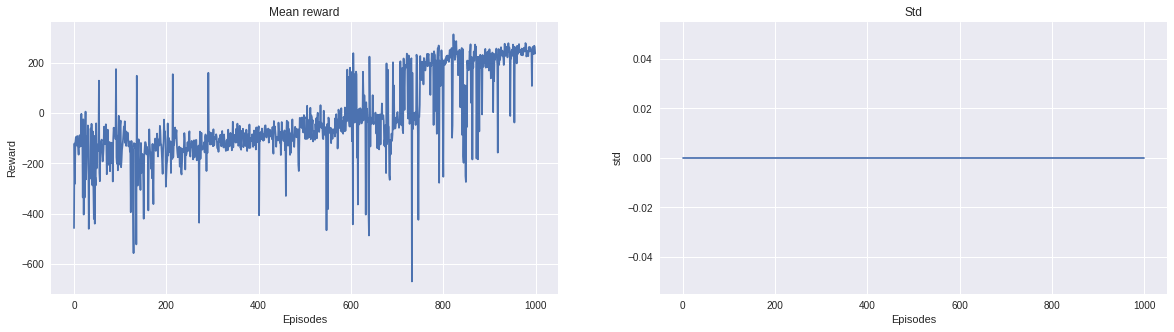

In [11]:
reward_history = RewardHistory()
for i in range(1):
    env = gym.make("LunarLander-v2")
    learner = DQNLinearLearner(env, double_Q=False)
    learner.train(1000)
    reward_history.append(learner.episode_rewards)

reward_history.plot()

In [12]:
env = wrap_env(gym.make("LunarLander-v2"))
for i in range(1):
    learner.run(env)
    show_video()

Total Reward:  261.75467065880946


# Extra challenge
Write an agent that takes in pixels from the gym environment as state. Expect training time to take many hours though.

grab the state with the following code rather than use the value returned from env.step(action)
```
screen = env.render(mode='rgb_array')
```

however remember to incorporate the screen from the previous state into current state somehow, so there's an observation of movement in time as part of your state input into the Q network. 

and since it's pixel states, you may want to switch out and use a CNN instead. 